# Lesson 2: Light Curves, Quality Flags, and Exoplanets

## Learning Goals: 
- Determine what quality flags mean.
- Explain the potential consequences for ignoring quality flags.
- Decide how to select an appropriate subset of data for analysis based on quality flags.
- List possible non-planetary sources of periodic signals in light curves.

## Lesson Outline:
- [Using example where planet signal is found, unless quality flags are factored in] Generate a lightcurve, phase fold to “find” a planet. 
- Reassess data using quality flags: should we really be using everything? Which flags are going to be problematic for our analysis?
- Appropriately filter the data to return a valid light curve, now without a planet.


## Imports
The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook, and you can expect to use some of these packages almost everytime you do astronomical research. A description of each import is as follows:

* `numpy` to handle array mathematics
* `pandas` to handle date conversions
* `fits` from astropy.io for accessing FITS files
* `lightkurve` for normalizing the flux in our light curves
* `Table` from astropy.table for creating tidy tables of the data
* `WCS` from astropy.wcs for storing World Coordinate Systems information 
* `SkyCoord` from astropy.coordinates for defining RA and Dec for targets
* `matplotlib.pyplot` for plotting data and images
* `Mast` and `Observations` from astroquery.mast for querying data and observations from the MAST archive

In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.mast import Mast, Observations
from astropy.io import ascii
from astropy.time import Time
import requests
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


### Choosing a Target
We can examine all the exoplanets examined by TESS on the Target Of Interest [(TOI) Catalog](https://tev.mit.edu/data/collection/193/).

The data we will be exploring today is of the star **TOI-1380**. TESS observed this star during Sectors 15 & 16, let's analyze a TESS lightcurve to try to figure out if there is a planet orbiting this star. 

### Query and Download TESS data

In [20]:
obs_table = Observations.query_criteria(objectname="TOI 1380", obs_collection = 'TESS', radius = "1s")

#take a look at the results of our query
obs_table.show_in_notebook()

idx,intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
0,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0015-1-1,320.8502765140274,43.65238482571886,image,"Ricker, George",3,58710.87770146,58736.89877356,1425.599379,600.0,1000.0,--,58756.3333334,N/A,--,15,POLYGON 325.69103700 51.11787800 331.39555400 40.33147800 316.97887200 35.74493600 309.37776600 46.19222400 325.69103700 51.11787800,--,--,PUBLIC,False,nan,27507600,70599431,70599431,0.0
1,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0016-1-2,324.1062639828475,45.13284501402439,image,"Ricker, George",3,58738.14878145,58762.81514278,1425.599358,600.0,1000.0,--,58782.3333334,N/A,--,16,POLYGON 324.74874100 53.62594900 335.89398400 44.22125500 323.27578500 36.65355700 312.60289300 44.83361500 324.74874100 53.62594900,--,--,PUBLIC,False,nan,27545553,70675319,70675319,0.0
2,science,TESS,SPOC,Photometer,TESS,TESS,Optical,274170255,--,tess2022217014003-s0055-0000000274170255-0242-s,316.446220131016,46.8451392680146,timeseries,"Ricker, George",3,59796.60170121528,59823.765985868056,120.0,600.0,1000.0,--,59841.0,G04242_G04039,--,55,CIRCLE 316.44622013 46.84513927 0.00138889,--,mast:TESS/product/tess2022217014003-s0055-0000000274170255-0242-s_lc.fits,PUBLIC,False,nan,93784678,178375055,178375055,0.0
3,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0055-3-2,312.25647634152466,45.557497011169225,image,"Ricker, George",3,59796.599052314814,59823.76597638889,475.199786,600.0,1000.0,--,59841.0,N/A,--,55,POLYGON 307.965722 37.679967 300.538923 48.290601 318.362775 53.079526 322.350637 41.906663 307.965722 37.679967,--,--,PUBLIC,False,nan,95133368,180182394,180182394,0.0
4,science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0056-3-1,311.83554610240543,46.84150109811228,image,"Ricker, George",3,59824.75429283565,59852.64048589121,158.399927,600.0,1000.0,--,59873.0,N/A,--,56,POLYGON 311.890927 38.69478 299.618952 45.757912 311.743107 55.285359 324.18886 46.302068 311.890927 38.69478,--,--,PUBLIC,False,nan,100164396,187595463,187595463,0.0


### Get Data Products

Now it is time to actually get the data products that we would like to analyse. For our purposes, we will be looking for "LC" files, LC stands for Light Curve and these files are pre-made light curves processed by the TESS pipeline. You can find more information about the different file types from TESS back in Lesson 1. 

In [21]:
#get all data products corresponding to the TESS observations we queried
data_products = Observations.get_product_list(obs_table)

#filter data products to just retrieve science light curves from TESS
filtered_data_products = Observations.filter_products(data_products,productSubGroupDescription="LC",productType = "SCIENCE",productGroupDescription = "Minimum Recommended Products")
filtered_data_products.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,93784678,TESS,timeseries,tess2022217014003-s0055-0000000274170255-0242-s,Light curves,S,mast:TESS/product/tess2022217014003-s0055-0000000274170255-0242-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,42dc8a2f6f,G04242_G04039,tess2022217014003-s0055-0000000274170255-0242-s_lc.fits,1987200,93784678,PUBLIC,3


### Downloading FITS file

File Image Transport System (FITS) is a file format designed to store, transmit, and manipulate scientific images and associated data. It is the most widely used file type in astronomical research. A FITS file consists of one or more Header + Data Units (HDUs), where the first HDU is called the primary HDU, or primary array. The primary array may be empty or contain an N-dimensional array of pixels, such as a 1-D spectrum, a 2-D image, or a 3-D data cube. 

For more info on FITS files, here is a link to the FITS official [website](https://fits.gsfc.nasa.gov/). 

Next we will be downloading the FITS file corresponding to the light curve we want to analyse, let's take a look at what is inside the file. 

In [22]:
data = Observations.download_products(filtered_data_products)
#Take a peek at the FITS file we downloaded
fits_file = data['Local Path'][0]

fits.info(fits_file)
fits_lc = fits.open(fits_file)

lc = fits_lc[1].data
lc.columns

Filename: ./mastDownload/TESS/tess2022217014003-s0055-0000000274170255-0242-s/tess2022217014003-s0055-0000000274170255-0242-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   19562R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

We can see that there are three extensions to this FITS file: PRIMARY, LIGHTCURVE, AND APERTURE. We will be interested in the LIGHTCURVE extension, so we have selected that extension and called it "lc". After printing out the data columns in lc, we see that there are columns for time and flux, which we will use to plot the data. 

Now we are ready to start analyzing this light curve. 

#### Plot raw light curves from data as a check

In [ ]:
flux = lc['SAP_FLUX'] #SAP flux column
flux_err = lc['SAP_FLUX_ERR'] #SAP flux error
time_lc = lc['TIME'] #time column
quality = lc['QUALITY'] #quality flags column

fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(time_lc, flux,'.', color = "red")
plt.ylabel("FLUX (e-/s)")
plt.xlabel("BJD-2457000")

### The LightKurve package
The LightKurve package is an open source python library of functions that make analysing light curves straightforward. From the [LightKurve documentation](https://docs.lightkurve.org/): "Lightkurve offers a user-friendly way to analyze time series data on the brightness of planets, stars, and galaxies. The package is focused on supporting science with NASA’s Kepler and TESS space telescopes, but can equally be used to analyze light curves obtained by your backyard telescope."

### Normalizing Flux

"Normalizing" changes the flux from being in units of raw electrons per second to being a fraction of the median flux value. This makes visualizing the flux much easier by displaying the total flux as a value out of 1, without changing anything about the data physically. We will be using the LightKurve package to normalize our data. 

### Phase Folding

"Phase folding" is the act of summing up the amount of flux within a certain period that corresponds to the period variation of the flux. This will make it so that our light curve is plotted as function of orbital phase instead of time. Since we know there is a planet around this star, the period we are looking for is the orbital period of the planet. In order to find the period we want to fold the data into, we will need to create a periodogram. A periodogram is a way to visualize oscillating data in the frequency domain rather than the time domain, this change of domain is done through a Fourier transform. There is a lot more information on this in the tutorial notebook [Creating Periodograms](https://spacetelescope.github.io/mast_notebooks/notebooks/Kepler/creating_periodograms/creating_periodograms.html?highlight=periodogram). We will use the LightKurve package to create the periodogram, use the periodogram to find the maximum period, and then perform the phase folding using that period. 


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

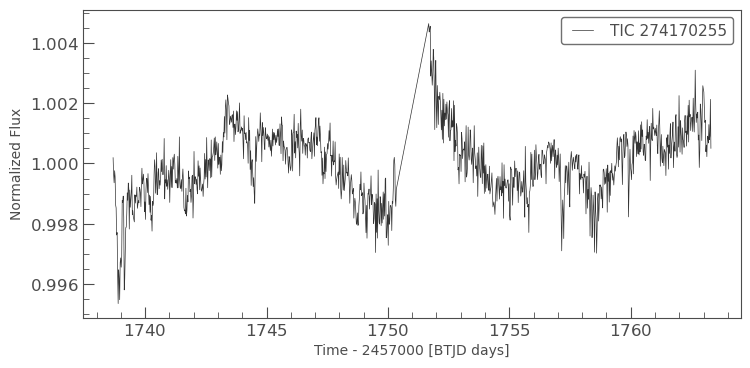

In [13]:
#get the light curve for our star
lc = lk.search_lightcurve('TOI 1380', sector = 16).download()#'HD 115447').download()
lc.plot()

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

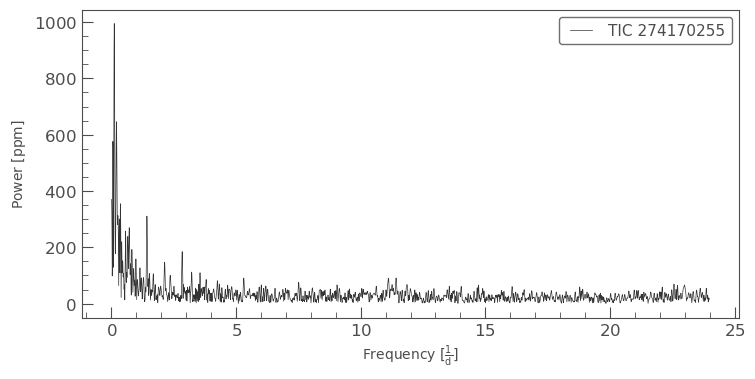

In [14]:
#create the periodogram
pg = lc.normalize(unit='ppm').to_periodogram()
pg.plot()

We now want to phase fold the flux corresponding to the orbital period of our potential exoplanet, this will be the maximum period we see in the periodogram. 

In [15]:
#get the orbital period of our planet
period = pg.period_at_max_power
period

#phase fold the light curve and normalize the flux
folded_lc = lc.fold(period)
folded_norm_lc = folded_lc.normalize()

Text(0.5, 0, 'ORBITAL PHASE')

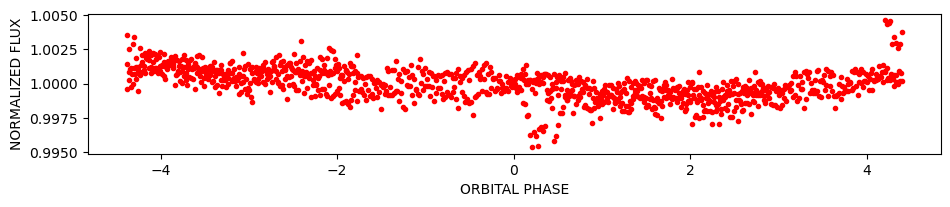

In [16]:
phase = folded_norm_lc['time'].value
flux = folded_norm_lc['flux']
quality = folded_norm_lc['quality']

#plot the normalized and phase folded light curve
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(phase, flux,'.', color = "red")
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('ORBITAL PHASE')

<!-- This doesn't look quite right, it seems that there are multiple dips occuring at the same phase and overlapping each other. Let's try to fold on a higher factor of the period to see if we can eliminate the extra dips and get a clean light curve. HINT: the fact that we see mutliple "transits" at the same phase and to the same depth probably indicates that this is not a true planetary transit. We will explore this further when we include the data quality flags.  -->

<!-- # fig = plt.figure(figsize = (11,4))

# fig.add_subplot(212)
# plt.plot(phase, norm_flux,'.', color = "red")
# plt.ylabel("NORMALIZED FLUX")
# plt.xlabel('ORBITAL PHASE')
# plt.xlim(2,3) #zoom in -->

At first glance, it might seem like we have a decent dip in our light curve, right around phase 0, indicating the transit of our exoplanet. However, we need to take into account the data quality flags for this observation. Once we clean up the data, this will provide us with a more accurate light curve and allow us to confirm or reject a transit. 


<!-- 
In our last lesson, we learned how to plot a light curve in order to search for exoplanets through the transit method. You may have noticed that some of our light curves were noisy or had a "messy" signal, in this lesson we will be learning how to improve the quality of our data and produce better light curves. The process to do this utilizes data quality flags.  -->

## What are data quality flags?

Data quality flags are an indicator in the data that tell the user whether or not the data has been corrected or is deemed poor quality. These flags are put in by the TESS team after making a statistical assessment of the data. We can use these quality flags to throw out bad data and clean up our light curves in order to get a less noisy signal and give us a better chance of finding an exoplanet transit. 

<b>The STScI website provides the following advice on TESS quality flags:<b>

"Not all of these pixels indicate that the data quality is bad. In many cases the flags simply indicate that a correction was made. For instance, bit 7 indicates that a cosmic ray was corrected on one of the pixels in the optimal aperture. If this is the only flag on this cadence, then the data is likely fine and should not be excluded from your analysis. Different science cases may warrant different usages of these flags. As a starting point, the following flags indicate that the cadence will likely be of lesser quality: 1,2,3,4,5,6,8,10,13, and 15. More specifically, a bit-wise AND with the binary number 0101001010111111 indicate cadences that are likely of lesser quality." For more information, check out the [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview) . 

### What if we ignore quality flags?
We saw from Lesson 1 that if we plot the data without taking into account any data quality flags, we see very messy signal in certain parts of the light curve. This noise can drown out a possibly faint planetary transit if the "dip" in the light curve from the transit is smaller than the variation of the bad data. Coversely, if we don't remove bad data, we run the risk of misidentifying a noisy signal as a transit.



### Clean up the data
By looking at the columns of the light curve data, we can see there are quality flags for anomolies in the data that we can now remove in order to get the best light curve possible. 

There are several quality flags in place, and you can learn about all of them in the [Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). For now, we will just be removing data that corresponds to the following flags:

- Bit 1. Attitude Tweak
- Bit 2. Safe Mode
- Bit 3. Coarse Point
- Bit 4. Earth Point
- Bit 5. Argabrightening Event (Sudden brightening across the CCD.)
- Bit 6. Reaction Wheel Desaturation
- Bit 8. Manual Exclude
- Bit 10. Impulsive outlier
- Bit 12. Straylight detected
- Bit 13. Scattered light
- Bit 15. Bad Calibration

In [17]:
bad_bits = np.array([1,2,3,4,5,6,8,10,12,13,15])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 
print(bad_data)

[False  True False ... False  True False]


### Re-plot the light curve after removing bad data

Text(0.5, 0, 'ORBITAL PHASE')

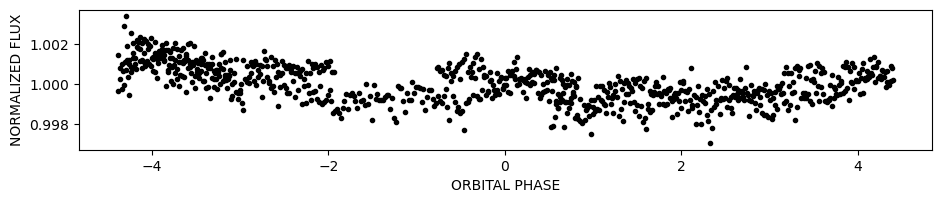

In [18]:
fig = plt.figure(figsize = (11,4))

fig.add_subplot(212)
plt.plot(phase[~bad_data], flux[~bad_data],'.', color = "black") 
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('ORBITAL PHASE')

### Over-plot the original light curve with the cleaned light curve to compare

Text(0.5, 0, 'PHASE')

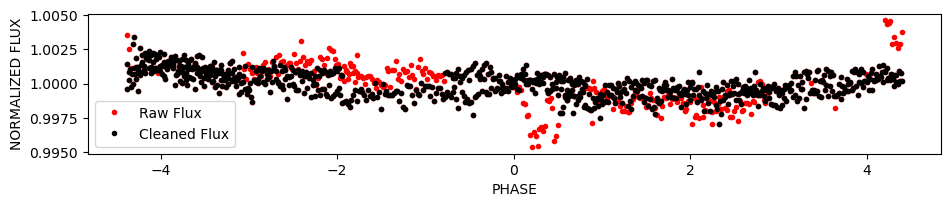

In [19]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(phase, flux,'.', label = 'Raw Flux', color = "red")
plt.plot(phase[~bad_data], flux[~bad_data],'.', label = 'Cleaned Flux', color = "black")
plt.legend()
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('PHASE')

Immediately we can see that what we may have concluded were transits of our exoplanet in our original light curve were actually just bad quality data which got removed when we cleaned up the original light curve. This is a prime example of how important it is to always account for the quality flags of our data when trying to draw conclusions from a visual analysis. 

## Homework

Let's look at how data quality flags affect TESS observations of TRAPPIST-1. This will require you to go back and recall how to query TESS observations of TRAPPIST-1 and retrieve a light curve fits file (HINT: go back to Lesson 1). Now,

(a) Write a Python code snippet that returns the count of observations for each quality flag bit value (0 to 15).

(b) Implement a Python code snippet that calculates the percentage of observations with quality flag bit values of 12 and 13.

(c) Write a Python code snippet that filters the dataset to exclude observations with quality flag bit values of 12 and 13.

## Additional Resources

**TOO ADD MORE RESOURCES**

Here is the link to the [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview) page all about data quality flags. 

## Acknowledgements

This notebook includes data collected with the TESS mission, obtained from the MAST data archive at the Space Telescope Science Institute (STScI). Funding for the TESS mission is provided by the NASA Explorer Program. STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.

Any published work that uses Astroquery should include a citation which can be found at [this link](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) or the BibTeX entry is available from the package itself with: `astroquery.__citation__`

### Notebook Information:
Author: Emma Lieb

Last Updated: 08/01/2023